# Overview of qa_tools


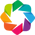

In [1]:
# First things first, set up holoviews for visualizations
import holoviews as hv
hv.notebook_extension('bokeh')

## Catalogs

The fundamental purpose of the `Catalog` object is to provide an interface to access desired columns from data tables on demand, without necessarily having to keep the whole contents in memory.

### ParquetCatalog

This is currently primarily implemented in the `ParquetCatalog` object, which uses the [dask](https://dask.pydata.org/en/latest/) interface to parquet tables.  Initialize a `ParquetCatalog` with the path to a parquet file, or a list of multiple such files. 

In [2]:
from explorer.catalog import ParquetCatalog

path = '/datasets/hsc/repo/rerun/RC/w_2018_04/DM-13256/plots/HSC-I/tract-9813/forced.parq'
catalog = ParquetCatalog(path)

The workhorse method of a `Catalog` is `get_columns`, which returns one or more columns (passed as a list) as a dask `DataFrame`.

In [3]:
catalog.get_columns(['coord_ra', 'coord_dec'])

Dask DataFrame Structure:
                  coord_ra coord_dec
npartitions=1                       
43158034708430849  float64   float64
43159164284835320      ...       ...
Dask Name: read-parquet, 1 tasks

Note that dask data structures are out-of-memory unless explicitly requested with `.compute()`, at which point they return a pandas `DataFrame`.  Note that this step takes a few seconds, as this is the first time data is being read from disk.  Note also that *only the requested columns are loaded into memory*, not the entire table block, as would be necessary with FITS or HDF.  This is the beauty of the parquet column-store table format, and a key feature enabling QA at scale.

In [4]:
catalog.get_columns(['coord_ra', 'coord_dec']).compute().head() # .head() to limit cell output

coord_ra  coord_dec
id                                    
43158167852417025  2.630391   0.026401
43158167852417026  2.630480   0.026404
43158167852417027  2.630681   0.026400
43158167852417028  2.630649   0.026409
43158167852417029  2.630604   0.026412

Aside from `get_columns`, there are a few other convenience attributes that can be useful:

In [5]:
# Names of all the available columns in the catalog
catalog.columns

['coord_ra',
 'coord_dec',
 'parent',
 'deblend_nChild',
 'base_TransformedCentroid_x',
 'slot_Centroid_x',
 'base_TransformedCentroid_y',
 'slot_Centroid_y',
 'base_TransformedCentroid_flag',
 'base_CircularApertureFlux_flag_badCentroid',
 'base_GaussianFlux_flag_badCentroid',
 'base_InputCount_flag_badCentroid',
 'base_PsfFlux_flag_badCentroid',
 'base_Variance_flag_badCentroid',
 'ext_convolved_ConvolvedFlux_0_flag_badCentroid',
 'ext_convolved_ConvolvedFlux_1_flag_badCentroid',
 'ext_convolved_ConvolvedFlux_2_flag_badCentroid',
 'ext_convolved_ConvolvedFlux_3_flag_badCentroid',
 'ext_convolved_ConvolvedFlux_flag_badCentroid',
 'ext_photometryKron_KronFlux_flag_badInitialCentroid',
 'modelfit_DoubleShapeletPsfApprox_flag_badCentroid',
 'slot_Centroid_flag',
 'undeblended_base_CircularApertureFlux_flag_badCentroid',
 'undeblended_base_PsfFlux_flag_badCentroid',
 'undeblended_ext_photometryKron_KronFlux_flag_badInitialCentroid',
 'base_InputCount_flag',
 'base_InputCount_value',
 'bas

In [6]:
# All columns that have bool datatype
catalog.flags

['base_TransformedCentroid_flag',
 'base_CircularApertureFlux_flag_badCentroid',
 'base_GaussianFlux_flag_badCentroid',
 'base_InputCount_flag_badCentroid',
 'base_PsfFlux_flag_badCentroid',
 'base_Variance_flag_badCentroid',
 'ext_convolved_ConvolvedFlux_0_flag_badCentroid',
 'ext_convolved_ConvolvedFlux_1_flag_badCentroid',
 'ext_convolved_ConvolvedFlux_2_flag_badCentroid',
 'ext_convolved_ConvolvedFlux_3_flag_badCentroid',
 'ext_convolved_ConvolvedFlux_flag_badCentroid',
 'ext_photometryKron_KronFlux_flag_badInitialCentroid',
 'modelfit_DoubleShapeletPsfApprox_flag_badCentroid',
 'slot_Centroid_flag',
 'undeblended_base_CircularApertureFlux_flag_badCentroid',
 'undeblended_base_PsfFlux_flag_badCentroid',
 'undeblended_ext_photometryKron_KronFlux_flag_badInitialCentroid',
 'base_InputCount_flag',
 'base_InputCount_flag_noInputs',
 'base_TransformedShape_flag',
 'base_GaussianFlux_flag_badShape',
 'slot_Shape_flag',
 'modelfit_DoubleShapeletPsfApprox_flag',
 'modelfit_DoubleShapeletPs

In [7]:
# in-memory dataframe of RA/Dec in degrees:
catalog.coords.head()

ra       dec
id                                     
43158167852417025  150.710282  1.512680
43158167852417026  150.715393  1.512820
43158167852417027  150.726899  1.512583
43158167852417028  150.725078  1.513109
43158167852417029  150.722519  1.513301

Let's now use holoviews to plot the ra-dec positions of the 2 million sources in this catalog.  This demonstrates some of the basic holoviews tools that are used throughout the qa_tools package.  First, we define the holoviews data containers, which are wrappers around the data (no copies made).

In [8]:
dset = hv.Dataset(catalog.coords)
pts = hv.Points(dset, kdims=['ra', 'dec'])

If there were less than ~$10^4$ points in this dataset, at this point we could just exectue `pts` and a scatter plot with all the points would be displayed.  However, we will bring the browser to its knees if we try to do that with $10^6$ points.  This is where the [datashader](https://github.com/bokeh/datashader) library comes in.  Datashader renders an on-the-fly aggregation of the underlying data, displaying the resulting image rather than passing individual points to the browser, and recomputing as you pan and zoom.  The `%%opts` magic function at the top of the cell is how you change the display defaults (the default plots in holoviews are pretty small).

In [9]:
%%opts RGB [width=500, height=500]
from holoviews.operation.datashader import datashade

datashade(pts) 

:DynamicMap   []

The above image basically just shows a density map, as the default aggregation is `count`, and there are only two columns in this dataset anyway.  However, you can do more interesting things, like have the aggregation be a mean of a different column.

In [10]:
# Add another column onto the coords dataframe
import pandas as pd
import datashader # for the different aggregator
import colorcet as cc # For colormaps

other_cols = ['base_InputCount_value', 'base_PsfFlux_flux']
df = pd.concat([catalog.coords, catalog.get_columns(other_cols).compute()], axis=1)
dset = hv.Dataset(df)
pts = hv.Points(dset, kdims=['ra', 'dec'], vdims=other_cols)

# To illustrate some more holoviews stuff
map1 = datashade(pts, aggregator=datashader.mean('base_InputCount_value')).relabel('Input Count')
map2 = datashade(pts, aggregator=datashader.mean('base_PsfFlux_flux'), cmap=cc.palette['fire']).relabel('Mean flux')

# Plot two side by side; axes automatically linked because they share dimension
map1 + map2 

:Layout
   .DynamicMap.Input_Count :DynamicMap   []
   .DynamicMap.Mean_flux   :DynamicMap   []

Having demonstrated basic visualization like this, let's do the same with loading multiple tracts into a single catalog object.

In [11]:
ls /datasets/hsc/repo/rerun/RC/w_2018_04/DM-13256/plots/HSC-I/

tract-9615/  tract-9697/  tract-9813/


In [12]:
import glob

# From PDR1
paths = glob.glob('/project/tmorton/DM-12043/SSP_WIDE_VVDS/plots/HSC-I/tract*/forced.parq')
vvds = ParquetCatalog(paths)
print(len(vvds.coords))

32243715


In [13]:
%%opts RGB [width=1200, height=400]
datashade(hv.Points(vvds.coords, kdims=['ra', 'dec']))

:DynamicMap   []

There are also some convenience subclasses of `ParquetCatalog` that allow you to access catalogs using `dataId`'s.

In [4]:
from lsst.daf.persistence import Butler

repo_path = '/datasets/hsc/repo/rerun/RC/w_2018_04/DM-13256/'
butler = Butler(repo_path)

In [5]:
from explorer.catalog import CoaddCatalog, VisitCatalog

coaddId = {'tract':9813, 'filter':'HSC-I'}
coaddCat = CoaddCatalog(butler, coaddId)
print(len(coaddCat.coords))

visitId = {'tract':9813, 'filter':'HSC-I', 'visit':1228}
visitCat = VisitCatalog(butler, visitId)
print(len(visitCat.coords))

2047238
258170


There's even a convenience function to know for what visits are parquet tables available in given repo, given a tract and filter: 

In [16]:
from explorer.utils import get_visits

get_visits(butler, 9813, 'HSC-I')

[1228,
 1230,
 1232,
 1238,
 1240,
 1242,
 1244,
 1246,
 1248,
 19658,
 19660,
 19662,
 19680,
 19682,
 19684,
 19694,
 19696,
 19698,
 19708,
 19710,
 19712,
 30482,
 30484,
 30486,
 30488,
 30490,
 30492,
 30494,
 30496,
 30498,
 30500,
 30502,
 30504]

(Note that all these `dataId`-based functions currently abuse the butler, using `pipe_analysis.utils.Filenamer`.)

## Calculating quantities with Functors

While one can always call `get_columns` to get what you want and then do calculations on them, it is usually more convenient to use a `Functor` object on a catalog.  There are several advantages to this: 

* A `Functor` knows what columns it needs to request from a catalog
* Simplifies many kinds of repeated calculations (e.g., magnitudes, magnitude differences, coordinates, labels, etc.)
* Allows a uniform interface to different kinds of catalogs (e.g., single or matched)
* You can easily apply the same calculations to multiple different catalogs, including different types of catalogs (e.g., single or matched)
* You can group multiple calculations together in a `CompositeFunctor`

In [4]:
from explorer.functors import Mag, MagDiff, Seeing, DeconvolvedMoments, Column, CustomFunctor

psfmag = Mag('base_PsfFlux')
print(psfmag.columns)
psfmag_df = psfmag(coaddCat)
psfmag_df.head()

['base_PsfFlux_flux']


/home/tmorton/.conda/envs/qa/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in log10
  return func(*args2)
/home/tmorton/.conda/envs/qa/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in log10
  return func(*args2)


id
43158167852417025    25.568261
43158167852417026    25.432726
43158167852417027    28.750510
43158167852417028    25.800125
43158167852417029    25.205901
Name: base_PsfFlux_flux, dtype: float64

In [5]:
seeing = Seeing()
print(seeing.columns)
seeing_df = seeing(coaddCat)
seeing_df.head()

('ext_shapeHSM_HsmPsfMoments_xx', 'ext_shapeHSM_HsmPsfMoments_yy')


id
43158167852417025    0.840815
43158167852417026    0.840202
43158167852417027    0.839401
43158167852417028    0.839288
43158167852417029    0.839393
dtype: float64

In [6]:
magdiff = MagDiff('modelfit_CModel', 'base_PsfFlux')
print(magdiff.columns)
magdiff_df = magdiff(coaddCat)
magdiff_df.head()

['modelfit_CModel_flux', 'base_PsfFlux_flux']


/home/tmorton/.conda/envs/qa/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in log10
  return func(*args2)
/home/tmorton/.conda/envs/qa/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in log10
  return func(*args2)


id
43158167852417029   -0.443873
43158167852417030   -0.162076
43158167852417031   -2.866012
43158167852417032    0.061599
43158167852417033   -0.379794
dtype: float64

There are also functors for labelling:

In [21]:
from explorer.functors import StarGalaxyLabeller

labeller = StarGalaxyLabeller()
print(labeller.columns)
label_df = labeller(coaddCat)
label_df.head()

['base_ClassificationExtendedness_value']


id
43158167852417025      null
43158167852417026      null
43158167852417027      null
43158167852417028      null
43158167852417029    galaxy
Name: label, dtype: category
Categories (3, object): [galaxy, star, null]

Or, we can do all at once:

In [22]:
from explorer.functors import CompositeFunctor

funcs = CompositeFunctor({'psf':psfmag, 'seeing':seeing, 'magdiff':magdiff, 'label':labeller})
print(funcs.columns)
df = funcs(coaddCat)
df.head()

['base_PsfFlux_flux', 'ext_shapeHSM_HsmPsfMoments_xx', 'ext_shapeHSM_HsmPsfMoments_yy', 'modelfit_CModel_flux', 'base_PsfFlux_flux', 'base_ClassificationExtendedness_value']


/home/tmorton/.conda/envs/qa/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in log10
  return func(*args2)
/home/tmorton/.conda/envs/qa/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in log10
  return func(*args2)


label   magdiff        psf    seeing
id                                                      
43158034708430849    null -0.017974  25.141479  0.845461
43158034708430850    null       NaN        NaN  0.845178
43158034708430851  galaxy -0.524188  24.271628  0.844449
43158034708430852  galaxy -0.229448  25.562212  0.844238
43158034708430853    null       NaN        NaN       NaN

And we can look at the distribution of these quantities (just to show how to do this using holoviews):

In [21]:
from holoviews.operation import histogram

dset = hv.Dataset(df)
hv.Layout([histogram(dset, dimension=d, num_bins=40) for d in ['psf', 'magdiff', 'seeing']])

:Layout
   .Histogram.I   :Histogram   [psf]   (psf_frequency)
   .Histogram.II  :Histogram   [magdiff]   (magdiff_frequency)
   .Histogram.III :Histogram   [seeing]   (seeing_frequency)

### Matched Catalogs

There are also several flavors of `Catalog` objects to handle matching catalogs to each other.  This is useful, for example, in matching a visit catalog, or multiple visits, to a coadd catalog, or matching two coadd catalogs to each other (e.g., to compared two different reruns).

In [6]:
from explorer.catalog import MatchedCatalog

matchedCat = MatchedCatalog(coaddCat, visitCat)

The catalogs match using the KD-tree implementation in `explorer.match.match_lists`.  Like everything else, the matching is lazy, so is only done when needed.  When you request columns from a `MatchedCatalog`, you get a tuple of two dataframes back.  However, as mentioned above, `get_columns` usually does not to be used directly; rather, computations should be done through a `Functor`.  For example:

In [23]:
psfmag(matchedCat).head()

INFO:root:275649 matched within 0.5 arcsec, 1771589 did not.
/home/tmorton/.conda/envs/qa/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in log10
  return func(*args2)
/home/tmorton/.conda/envs/qa/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in log10
  return func(*args2)


id
43158305291375210    0.952731
43158305291375385    0.324429
43158305291375408    0.228612
43158305291375521    0.162533
43158305291375524    0.104674
dtype: float64

These numbers may be unexpected, as they do not look like PSF magnitudes.  This is because the default way that a `MatchedCatalog` computes a functor is by returning a dataframe of the difference (first minus second).  The desired behavior can be made explicit, if something else is desired:

In [8]:
print(psfmag(matchedCat, how='first').head())
print(psfmag(matchedCat, how='second').head())
print(psfmag(matchedCat, how='all').head())

INFO:root:275649 matched within 0.5 arcsec, 1771589 did not.
/home/tmorton/.conda/envs/qa/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in log10
  return func(*args2)
/home/tmorton/.conda/envs/qa/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in log10
  return func(*args2)


id
43158305291375210    19.197413
43158305291375385    21.937229
43158305291375408    24.011697
43158305291375521    23.366478
43158305291375524    22.535238
dtype: float64
id
43158305291375210    18.244683
43158305291375385    21.612800
43158305291375408    23.783085
43158305291375521    23.203945
43158305291375524    22.430564
dtype: float64
                      ntymze     txvybl
id                                     
43158305291375210  19.197413  18.244683
43158305291375385  21.937229  21.612800
43158305291375408  24.011697  23.783085
43158305291375521  23.366478  23.203945
43158305291375524  22.535238  22.430564


In [35]:
funcs = CompositeFunctor({'psf':psfmag, 'seeing':seeing, 'label':labeller})
funcs(matchedCat, how='all').head()

INFO:root:275649 matched within 0.5 arcsec, 1771589 did not.
/home/tmorton/.conda/envs/qa/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in log10
  return func(*args2)
/home/tmorton/.conda/envs/qa/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in log10
  return func(*args2)


label                psf               seeing          
                   ntymze  txvybl     ntymze     txvybl    ntymze    txvybl
id                                                                         
43158305291375210    null    null  19.197413  18.244683  0.942669  1.774333
43158305291375385  galaxy    null  21.937229  21.612800  0.960174  1.809508
43158305291375408    null    null  24.011697  23.783085  0.936410  1.823004
43158305291375521  galaxy  galaxy  23.366478  23.203945  0.960205  1.810353
43158305291375524  galaxy  galaxy  22.535238  22.430564  0.927926  1.794848

Note how calling a composite functor on a `MatchedCatalog` gives you a dataframe with a multi-level index.  Also note that we did not initialize the catalogs we are using with names.  So instead, they are given names of random strings of characters, seeded by the hash of the catalog filename(s) for consistency: catalogs will thus have consistent "random" character-string names. 

### Multi-matched Catalogs

There is also a matched catalog implementation that allows for multiple catalogs to all match to a single one; this is particularly useful for multi-visit -> coadd matching, to investigate things like photometric or astrometric repeatability, or to see how quantities vary from visit to visit.

In [7]:
from explorer.utils import get_visits
from explorer.catalog import MultiMatchedCatalog

visits = get_visits(butler, 9813, 'HSC-I')[:3]
multiMatchedCat = MultiMatchedCatalog(coaddCat, [VisitCatalog(butler, {'tract':9813, 'filter':'HSC-I', 'visit':v}, name=v) for v in visits])

In [36]:
funcs(multiMatchedCat).dropna(how='any').sample(10)

/home/tmorton/.conda/envs/qa/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in log10
  return func(*args2)
/home/tmorton/.conda/envs/qa/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in log10
  return func(*args2)
INFO:root:275649 matched within 0.5 arcsec, 1771589 did not.
INFO:root:276409 matched within 0.5 arcsec, 1770829 did not.
INFO:root:294747 matched within 0.5 arcsec, 1752491 did not.


label                                psf             \
                    coadd    1228    1230    1232      coadd       1228   
id                                                                        
43158734788135724  galaxy  galaxy  galaxy  galaxy  24.788009  24.444935   
43159151399954186  galaxy  galaxy  galaxy  galaxy  23.104006  23.023369   
43158588759221337  galaxy  galaxy  galaxy  galaxy  22.120620  21.939822   
43158442730351985    null    star    star    star  18.167782  17.863753   
43158593054188454  galaxy  galaxy  galaxy  galaxy  24.028867  23.896371   
43158180737344634  galaxy  galaxy  galaxy  galaxy  22.431296  22.553739   
43158867932119636  galaxy  galaxy  galaxy  galaxy  21.048292  20.918772   
43158472795126718  galaxy  galaxy  galaxy  galaxy  23.273305  23.143526   
43158872227086317  galaxy  galaxy  galaxy  galaxy  21.740333  21.561935   
43159005371086590  galaxy  galaxy  galaxy  galaxy  25.463263  24.608890   

                                           seeing                      \
                        1230       1232     coadd      1228      1230   
id                                                                      
43158734788135724  24.825001  24.554654  1.032411  1.635370  1.708157   
43159151399954186  23.140723  23.060870  1.080377  1.953397  2.071097   
43158588759221337  21.910367  21.964184  1.039879  1.655003  1.715929   
43158442730351985  17.866338  17.849835  0.960871  1.897110  2.100235   
43158593054188454  23.793716  23.869001  1.022566  1.645148  1.723964   
43158180737344634  22.224363  22.247695  0.954172  1.874136  1.991816   
43158867932119636  20.908980  20.927132  1.015709  1.730196  1.797580   
43158472795126718  23.171756  23.236232  1.092717  1.731104  1.755663   
43158872227086317  21.573238  21.571533  1.031997  1.669616  1.747838   
43159005371086590  24.903670  24.846998  1.120976  1.808221  1.871184   

                             
                       1232  
id                           
43158734788135724  1.598652  
43159151399954186  1.952526  
43158588759221337  1.649994  
43158442730351985  1.876271  
43158593054188454  1.587536  
43158180737344634  1.836650  
43158867932119636  1.688925  
43158472795126718  1.669799  
43158872227086317  1.663081  
43159005371086590  1.831671

### MultiBand Catalogs

Another type of multi-matched catalog is a `MultiBandCatalog`, which is a special subclass of a `MultiMatchedCatalog`, inheriting through `IDMatchedCatalog`, where matching is done by ID rather than by position.  

In [8]:
from explorer.catalog import MultiBandCatalog

filters = ['HSC-G', 'HSC-R', 'HSC-I']
multiBandCat = MultiBandCatalog({f:CoaddCatalog(butler, {'tract':9813, 'filter':f}) for f in filters})

In [26]:
funcs(multiBandCat).sample(10)

/home/tmorton/.conda/envs/qa/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in log10
  return func(*args2)
/home/tmorton/.conda/envs/qa/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in log10
  return func(*args2)


label                        psf                        \
                    HSC-G   HSC-R   HSC-I      HSC-G      HSC-R      HSC-I   
id                                                                           
43159009666049559    star    star    star  26.647184  27.010154  26.984412   
43158855047221487  galaxy  galaxy  galaxy  26.181394  24.584148  23.109391   
43158185032318991  galaxy  galaxy  galaxy  27.052485  26.321781  26.018547   
43158472795117058  galaxy  galaxy  galaxy  29.324120  28.548352  27.429141   
43158588759234143  galaxy    star    star  29.171818  28.437369  26.966398   
43159151399935351  galaxy    star  galaxy  26.836928  26.923859  27.109528   
43158326766239190  galaxy  galaxy    star  28.447260  28.174813  27.587527   
43158335356149691  galaxy    null  galaxy  25.761736        NaN  25.278975   
43158872227073541  galaxy  galaxy  galaxy  25.284187  25.453547  25.282440   
43158863637147281  galaxy  galaxy  galaxy  26.251854  25.891058  25.677674   

                     seeing                      
                      HSC-G     HSC-R     HSC-I  
id                                               
43159009666049559  1.750485  0.898077  1.087149  
43158855047221487  1.761045  0.859900  1.020531  
43158185032318991  1.687206  0.899735  1.106478  
43158472795117058  1.653809  0.893911  1.064097  
43158588759234143  1.696529  0.806412  1.025754  
43159151399935351  1.829259  0.895784  1.129711  
43158326766239190  1.659955  0.804829  1.064263  
43158335356149691  1.964818       NaN  1.031417  
43158872227073541  1.697107  0.853853  1.001535  
43158863637147281  1.760609  0.813337  1.032615

## QADataset

All the above discussion of `Catalog` and `Functor` objects provides all the necessary building blocks for making all sorts of kinds of plots.  However, it is usually easiest to organize everything with the `QADataset` object.

In [9]:
from explorer.functors import MagDiff, Column, Seeing
from explorer.dataset import QADataset

magdiff = MagDiff('modelfit_CModel', 'base_PsfFlux')
magdiff_Gauss = MagDiff('base_GaussianFlux', 'base_PsfFlux')
funcs = {'cmodel':magdiff, 'count': Column('base_InputCount_value'), 'seeing':Seeing()}
visitFuncs = {'gauss':magdiff_Gauss, 'seeing':Seeing()}

coaddData = QADataset(coaddCat, funcs)
visitData = QADataset(visitCat, visitFuncs)
matchedData = QADataset(matchedCat, visitFuncs)
multiData = QADataset(multiMatchedCat, visitFuncs)
multiBandData = QADataset(multiBandCat, funcs)

The `.df` attribute (lazily computed) is a pandas dataframe that holds all the columns of the requested functors, *plus* columns for the coordinates, ccd/patch information, a label, and an `x` column, which by default is the PSF mag.  The `.ds` attribute is an `hv.Dataset` wrapper of that data.  Here is how all these look for all the different kinds of catalogs used:

In [14]:
print(coaddData.ds)
coaddData.df.head()

/home/tmorton/.conda/envs/qa/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in log10
  return func(*args2)
/home/tmorton/.conda/envs/qa/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in log10
  return func(*args2)


:Dataset   [ra,dec,x,label,patchId]   (cmodel,count,seeing)


cmodel  count       dec   label patchId          ra  \
id                                                                         
43158167852417029 -0.443873      1  1.513301  galaxy     1,0  150.722519   
43158167852417030 -0.162076      1  1.513328  galaxy     1,0  150.719042   
43158167852417031 -2.866012      1  1.514042  galaxy     1,0  150.714058   
43158167852417032  0.061599      1  1.513720    star     1,0  150.722170   
43158167852417033 -0.379794      1  1.514011  galaxy     1,0  150.725099   

                     seeing          x  
id                                      
43158167852417029  0.839393  25.205901  
43158167852417030  0.839640  25.194752  
43158167852417031  0.839816  20.802649  
43158167852417032  0.839230  25.717219  
43158167852417033  0.838912  23.603111

In [15]:
print(visitData.ds)
visitData.df.head()

/home/tmorton/.conda/envs/qa/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in log10
  return func(*args2)


:Dataset   [ra,dec,x,label,ccdId]   (gauss,seeing)


ccdId       dec     gauss label          ra    seeing  \
id                                                                        
1054843967897601      0  1.485532 -0.533495  null  150.319815  1.996415   
1054843967897602      0  1.500627 -0.191017  null  150.320190  1.979837   
1054843967897603      0  1.537180  1.001439  null  150.320702  1.945378   
1054843967897604      0  1.539046 -1.337229  null  150.321007  1.943698   
1054843967897605      0  1.524884 -0.337612  null  150.320945  1.955742   

                          x  
id                           
1054843967897601  23.835072  
1054843967897602  21.678365  
1054843967897603  21.235446  
1054843967897604  24.341243  
1054843967897605  24.499448

In [12]:
print(matchedData.ds)
matchedData.df.head()

:Dataset   [ra,dec,x,label,patchId]   (gauss,seeing,match_distance)


dec  gauss   label  patchId          ra  seeing  \
id                                                                        
43158034708430849  1.688999    NaN    null      NaN  150.897433     NaN   
43158034708430850  1.689886    NaN    null      NaN  150.898086     NaN   
43158034708430851  1.691780    NaN  galaxy      NaN  150.899129     NaN   
43158034708430852  1.692589    NaN  galaxy      NaN  150.899847     NaN   
43158034708430853  1.693197    NaN    null      NaN  150.901122     NaN   

                           x  match_distance  
id                                            
43158034708430849  25.141479             NaN  
43158034708430850        NaN             NaN  
43158034708430851  24.271628             NaN  
43158034708430852  25.562212             NaN  
43158034708430853        NaN             NaN

In [13]:
print(multiData.ds)
multiData.df.head()

/home/tmorton/.conda/envs/qa/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in log10
  return func(*args2)
/home/tmorton/.conda/envs/qa/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in log10
  return func(*args2)
INFO:root:275649 matched within 0.5 arcsec, 1771589 did not.
INFO:root:276409 matched within 0.5 arcsec, 1770829 did not.
INFO:root:294747 matched within 0.5 arcsec, 1752491 did not.


:Dataset   [ra,dec,x,label,ccdId]   (gauss,seeing,match_distance)


ccdId                      dec                      \
                  coadd 1228 1230 1232     coadd      1228      1230   
id                                                                     
43158034708430849   NaN  NaN  NaN  NaN  1.688999  1.688999  1.688999   
43158034708430850   NaN  NaN  NaN  NaN  1.689886  1.689886  1.689886   
43158034708430851   NaN  NaN  NaN  NaN  1.691780  1.691780  1.691780   
43158034708430852   NaN  NaN  NaN  NaN  1.692589  1.692589  1.692589   
43158034708430853   NaN  NaN  NaN  NaN  1.693197  1.693197  1.693197   

                                gauss       ...  seeing               x       \
                       1232     coadd 1228  ...    1230 1232      coadd 1228   
id                                          ...                                
43158034708430849  1.688999  0.084270  NaN  ...     NaN  NaN  25.141479  NaN   
43158034708430850  1.689886       NaN  NaN  ...     NaN  NaN        NaN  NaN   
43158034708430851  1.691780 -0.381068  NaN  ...     NaN  NaN  24.271628  NaN   
43158034708430852  1.692589  0.094880  NaN  ...     NaN  NaN  25.562212  NaN   
43158034708430853  1.693197       NaN  NaN  ...     NaN  NaN        NaN  NaN   

                            match_distance                  
                  1230 1232           1228 1230 1232 coadd  
id                                                          
43158034708430849  NaN  NaN            NaN  NaN  NaN   0.0  
43158034708430850  NaN  NaN            NaN  NaN  NaN   0.0  
43158034708430851  NaN  NaN            NaN  NaN  NaN   0.0  
43158034708430852  NaN  NaN            NaN  NaN  NaN   0.0  
43158034708430853  NaN  NaN            NaN  NaN  NaN   0.0  

[5 rows x 32 columns]

In [16]:
print(multiBandData.ds)
multiBandData.df.head()

/home/tmorton/.conda/envs/qa/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in log10
  return func(*args2)
/home/tmorton/.conda/envs/qa/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in log10
  return func(*args2)


:Dataset   [ra,dec,x,label,patchId]   (cmodel,count,seeing)


cmodel             count                   dec label        \
                   HSC-G HSC-R HSC-I HSC-G HSC-R HSC-I       dec HSC-G HSC-R   
id                                                                             
43158034708430849    NaN   NaN   NaN   NaN   NaN   NaN  1.688999   NaN   NaN   
43158034708430850    NaN   NaN   NaN   NaN   NaN   NaN  1.689886   NaN   NaN   
43158034708430851    NaN   NaN   NaN   NaN   NaN   NaN  1.691780   NaN   NaN   
43158034708430852    NaN   NaN   NaN   NaN   NaN   NaN  1.692589   NaN   NaN   
43158034708430853    NaN   NaN   NaN   NaN   NaN   NaN  1.693197   NaN   NaN   

                        patchId                      ra seeing              \
                  HSC-I   HSC-G HSC-R HSC-I          ra  HSC-G HSC-R HSC-I   
id                                                                           
43158034708430849   NaN     NaN   NaN   NaN  150.897433    NaN   NaN   NaN   
43158034708430850   NaN     NaN   NaN   NaN  150.898086    NaN   NaN   NaN   
43158034708430851   NaN     NaN   NaN   NaN  150.899129    NaN   NaN   NaN   
43158034708430852   NaN     NaN   NaN   NaN  150.899847    NaN   NaN   NaN   
43158034708430853   NaN     NaN   NaN   NaN  150.901122    NaN   NaN   NaN   

                      x              
                  HSC-G HSC-R HSC-I  
id                                   
43158034708430849   NaN   NaN   NaN  
43158034708430850   NaN   NaN   NaN  
43158034708430851   NaN   NaN   NaN  
43158034708430852   NaN   NaN   NaN  
43158034708430853   NaN   NaN   NaN